# 使用 朴素贝叶斯、随机森林、逻辑回归、支持向量机做文本情感分类




In [ ]:
import pandas as pd
import numpy as np

# 文本预处理
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 特征提取
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

import pickle

## 1. 导入数据

数据集分为训练70%和测试30%


In [ ]:
df_train = pd.read_csv('/content/data_train.csv')
df_test = pd.read_csv('/content/data_test.csv')

X_train = df_train.Text  #文本
X_test = df_test.Text

y_train = df_train.Emotion  # 情感标签
y_test = df_test.Emotion

class_names = ['joy', 'sadness', 'anger', 'neutral', 'fear']

data = pd.concat([df_train, df_test])
#数据大小
print('size of training set: %s' % (len(df_train['Text'])))
print('size of validation set: %s' % (len(df_test['Text'])))

# 显示每个情感类别的出现次数
print(data.Emotion.value_counts())

data.head()


size of training set: 7934
size of validation set: 3393
Emotion
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: count, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...


## 2. 文本预处理



In [ ]:
def preprocess_and_tokenize(data):
    data = re.sub("(<.*?>)", "", data)
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    # 去除标点符号和非 ASCII 数字
    data = re.sub("(\\W|\\d)", " ", data)
    # 去除多余的空格
    data = data.strip()
    # 分词
    data = word_tokenize(data)
    # 词干化
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
    return stem_data

## 3. 文本表示




In [ ]:
# TFIDF，单词和双词模型
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))
import nltk
nltk.download('punkt_tab')
# 在整个语料库上进行训练
vect.fit_transform(data.Text)
# 转换为向量表示
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


混淆矩阵，之后会用在每一个模型做评估

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'  # 归一化后的混淆矩阵
        else:
            title = 'Confusion matrix, without normalization'  # 未归一化的混淆矩阵

    cm = confusion_matrix(y_true, y_pred)

    # 混淆矩阵归一化
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    return ax

## 4. 朴素贝叶斯



Accuracy: 66.90%

F1 Score: 66.90

COnfusion Matrix:
 [[469  32  44  28 120]
 [ 74 416  56  16 117]
 [ 56  17 475  68  91]
 [ 62  19  76 385  96]
 [ 68  20  48  15 525]]


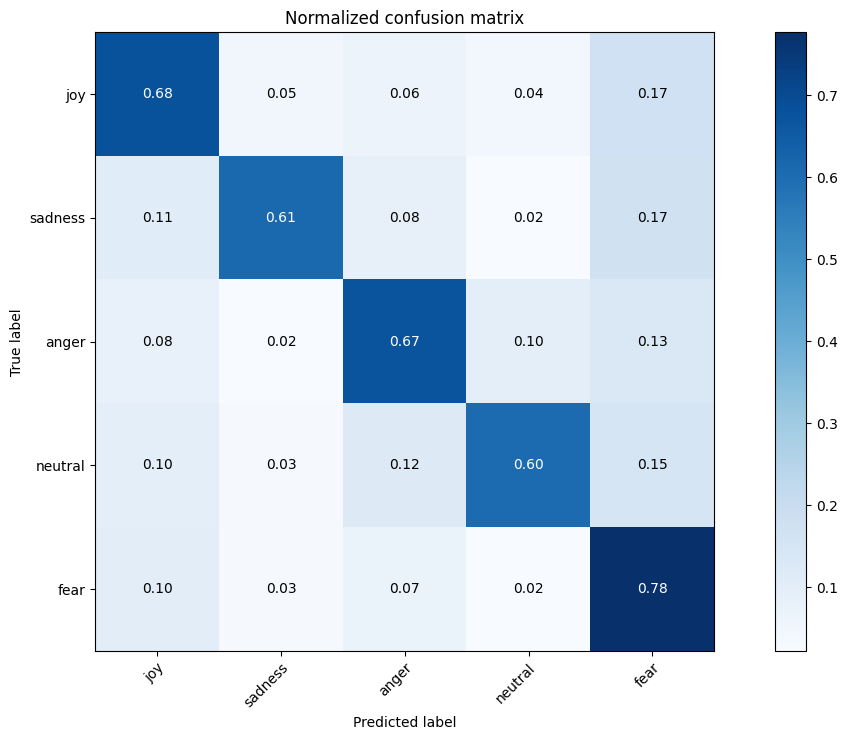

In [ ]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  随机森林

Accuracy: 63.25%

F1 Score: 63.25

COnfusion Matrix:
 [[395  95  54  80  69]
 [ 68 437  50  67  57]
 [ 69  62 427 104  45]
 [ 40  24  47 499  28]
 [ 98  64  68  58 388]]


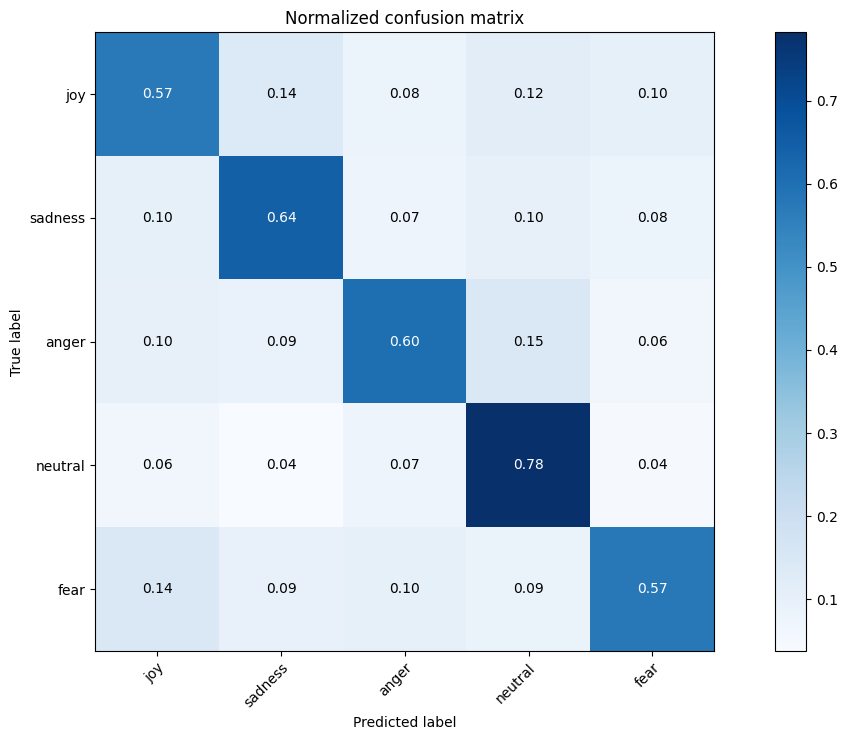

In [ ]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  逻辑回归

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 69.47%

F1 Score: 69.47

COnfusion Matrix:
 [[460  64  43  68  58]
 [ 64 483  40  53  39]
 [ 56  34 477 101  39]
 [ 42  23  41 498  34]
 [ 83  60  51  43 439]]


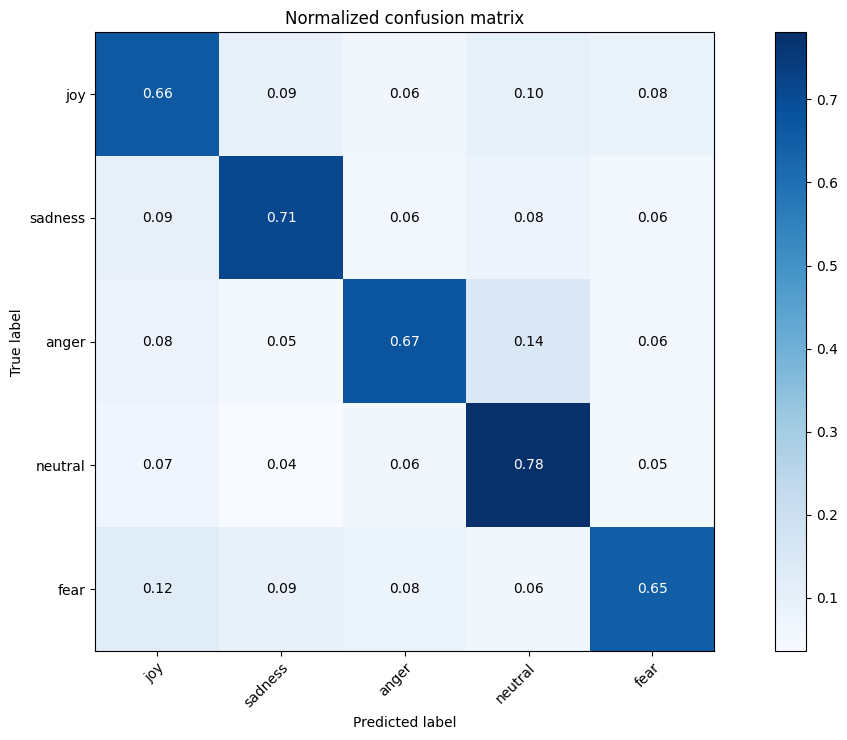

In [ ]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  支持向量机

Accuracy: 72.80%

F1 Score: 72.80

COnfusion Matrix:
 [[490  49  41  58  55]
 [ 53 509  33  40  44]
 [ 50  33 499  90  35]
 [ 34  23  38 505  38]
 [ 71  43  53  42 467]]


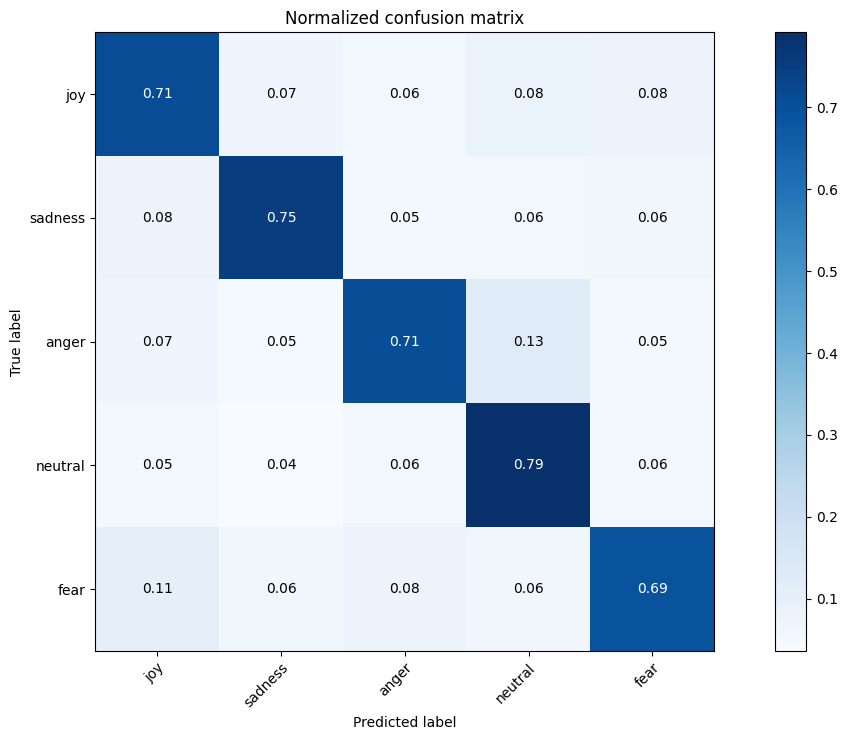

In [ ]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

## 4. 部署保存


In [ ]:
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

In [ ]:
import os
import pickle

filename = 'models/tfidf_svm.sav'
os.makedirs(os.path.dirname(filename), exist_ok=True)
pickle.dump(svm_model, open(filename, 'wb'))

In [ ]:
model = pickle.load(open(filename, 'rb'))

message = 'delivery was hour late and my pizza is cold!'
model.predict([message])

array(['anger'], dtype=object)